## Imports

In [28]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import pandas as pd
import seaborn as sns
from pycparser.ply.cpp import Preprocessor

## Create map

In [29]:
from classes.simulation import Map

gym = Map(num_robots=5).load('./maps/base.txt')

gym.get_map()

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 1

# Start of Decision Transformer

In [30]:
class Attention(nn.Module):
    def __init__(self,
                 embedding_size,
                 query_size,
                 n_heads, has_mask=False):
        super(Attention, self).__init__()
        self.embedding_size = embedding_size
        self.d_k = query_size
        self.n_heads = n_heads

    def forward(self, x: torch.Tensor):
        dims = x.shape
        head_dims = list(dims)
        head_dims[-1] //= self.n_heads

        repeat_dims = (3, *[1] * (len(dims)))
        qkv = x.view(1, *dims).repeat(*repeat_dims)
        qkv = qkv.view(3, self.n_heads, *head_dims)

        q, k, v = qkv[0], qkv[1], qkv[2]
        scores = torch.matmul(q, k.transpose(-2, -1))

        p_att = F.softmax(scores / (self.d_k ** 0.5), -1)

        attention = torch.matmul(p_att, v)
        attention = attention.transpose(1, 2).contiguous()
        attention = attention.view((-1, self.embedding_size,))

        return attention


In [31]:
class Block(nn.Module):
    def __init__(self, hidden_dim, context_window, n_heads):
        super(Block, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_window = context_window
        self.n_head = n_heads
        self.layers_size = 4 * context_window * hidden_dim

        self.attention_layer = Attention(hidden_dim, context_window, n_heads)
        self.norm_mid_layer = nn.LayerNorm(self.layers_size, self.layers_size)
        self.forward_layer = nn.Linear(self.layers_size, self.layers_size)
        self.norm_end_layer = nn.LayerNorm(self.layers_size, self.layers_size)

    def forward(self, embeds):
        processed_embeds = self.attention_layer(embeds) + embeds
        processed_embeds = self.norm_mid_layer(processed_embeds.view(-1))
        forward_embeds = self.forward_layer(processed_embeds)
        end_embeds = self.norm_end_layer(forward_embeds + processed_embeds)
        return end_embeds.view(-1, self.hidden_dim)


In [32]:
class Preprocess(nn.Module):
    def __init__(self,
                 context_window,
                 hidden_dim,
                 n_heads,
                 reward_dim,
                 map_dim,
                 path_dim,
                 action_dim):
        super(Preprocess, self).__init__()
        self.context_window = context_window * 4
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads

        self.reward_dim = reward_dim
        self.map_dim = map_dim
        self.path_dim = path_dim
        self.action_dim = action_dim

        self.reward_embed = nn.Linear(reward_dim, hidden_dim)
        self.map_embed = nn.Linear(map_dim, hidden_dim)
        self.path_embed = nn.Linear(4 * path_dim, hidden_dim)
        self.action_embed = nn.Linear(action_dim, hidden_dim)
        self.timestep_embed = nn.Embedding(context_window, hidden_dim)

    def forward(self, rewards, maps, paths, actions):
        reward_tokens = self.reward_embed(rewards)
        map_tokens = self.map_embed(maps)
        path_tokens = self.path_embed(paths)
        action_tokens = self.action_embed(actions)

        embeds = torch.zeros((self.context_window, self.hidden_dim))
        embeds[:len(reward_tokens) * 4:4] = reward_tokens
        embeds[1:len(map_tokens) * 4:4] = map_tokens
        embeds[2:len(path_tokens) * 4:4] = path_tokens
        embeds[3:len(action_tokens) * 4:4] = action_tokens

        timesteps = torch.arange(0, self.context_window / 4, dtype=torch.long)
        timesteps = timesteps.unsqueeze(0).repeat(1, 4).flatten()
        timesteps = self.timestep_embed(timesteps)

        embeds += timesteps
        return embeds

In [33]:
class DecisionTransformer(nn.Module):
    def __init__(self,
                 context_window,
                 hidden_dim,
                 n_heads,
                 n_decoders,
                 reward_dim,
                 map_dim,
                 path_dim,
                 action_dim
                 ):
        """
        :param context_window: size of window
        :param hidden_dim: Dimension of token after translation (HIDDEN_DIM,)
        :param n_heads: Number of attention heads
        :param reward_dim: Dimension of reward, shape of reward (CONTEXT_WINDOW, REWARD_DIM,)
        :param map_dim: Dimension of map (CONTEXT_WINDOW, MAP_DIM,), map_dim is a number = width*height
        :param path_dim: Dimension of path (CONTEXT_WINDOW, PATH_DIM, 4,)
        :param action_dim: Dimension of action (CONTEXT_WINDOW, 1,)
        """
        if hidden_dim % n_heads != 0:
            raise Exception("Hidden dim cant be divided by number of attention heads")

        super(DecisionTransformer, self).__init__()
        self.preprocess = Preprocess(context_window, hidden_dim, n_heads,
                                     reward_dim, map_dim, path_dim, action_dim)
        self.decoders = nn.Sequential(*[Block(hidden_dim, context_window, n_heads) for _ in range(n_decoders)])

    def forward(self, rewards, maps, paths, actions):
        embeds = self.preprocess(rewards, maps, paths, actions)
        values = self.decoders(embeds)
        return values


In [34]:
model = DecisionTransformer(context_window=60,
                            hidden_dim=36,
                            n_heads=4,
                            n_decoders=6,
                            reward_dim=1,
                            map_dim=gym.get_area(),
                            path_dim=gym.get_nr_robots(),
                            action_dim=gym.get_nr_robots())
model

DecisionTransformer(
  (preprocess): Preprocess(
    (reward_embed): Linear(in_features=1, out_features=36, bias=True)
    (map_embed): Linear(in_features=300, out_features=36, bias=True)
    (path_embed): Linear(in_features=20, out_features=36, bias=True)
    (action_embed): Linear(in_features=5, out_features=36, bias=True)
    (timestep_embed): Embedding(60, 36)
  )
  (decoders): Sequential(
    (0): Block(
      (attention_layer): Attention()
      (norm_mid_layer): LayerNorm((8640,), eps=8640, elementwise_affine=True)
      (forward_layer): Linear(in_features=8640, out_features=8640, bias=True)
      (norm_end_layer): LayerNorm((8640,), eps=8640, elementwise_affine=True)
    )
    (1): Block(
      (attention_layer): Attention()
      (norm_mid_layer): LayerNorm((8640,), eps=8640, elementwise_affine=True)
      (forward_layer): Linear(in_features=8640, out_features=8640, bias=True)
      (norm_end_layer): LayerNorm((8640,), eps=8640, elementwise_affine=True)
    )
    (2): Block(
 

In [35]:
gym.get_area(), gym.get_flattened_map().shape

(300, (300,))

<Axes: >

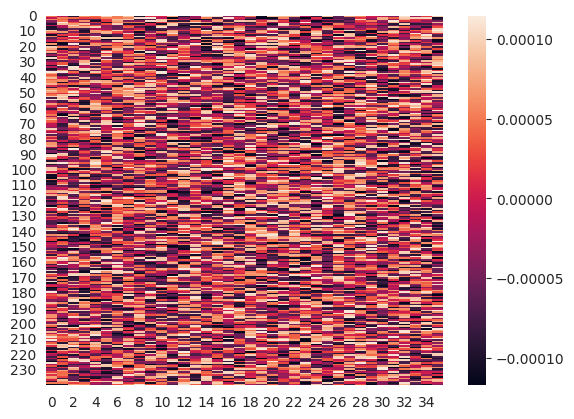

In [36]:
res = model(
    rewards=torch.tensor([[0], [0]], dtype=torch.float32),
    maps=torch.tensor([gym.get_flattened_map(), gym.get_flattened_map()], dtype=torch.float32),
    paths=torch.tensor([gym.get_paths().flatten(), gym.get_paths().flatten()], dtype=torch.float32),
    actions=torch.tensor([[0] * gym.get_nr_robots(), [0] * gym.get_nr_robots()], dtype=torch.float32),
)
sns.heatmap(res.detach().numpy())